In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

Welcome to JupyROOT 6.30/06


In [262]:
channel = 5

In [263]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [289]:
PATH = '../Dati/21-03/Run_ch5_Cs_Measurements_Only_3_21_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [290]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

In [291]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 5 = 87784
#Noise ripulita su ch 5 = 223388


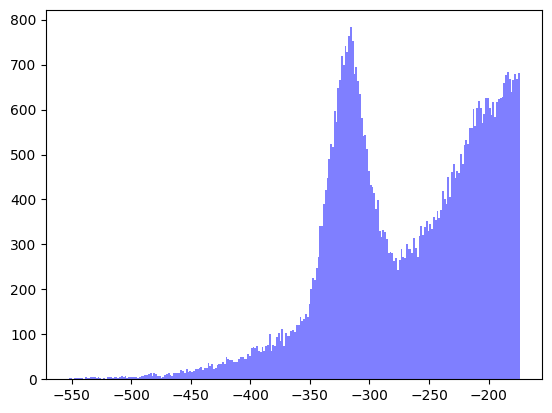

In [298]:
Nbin = 250
bin_lims = [int(Nbin *45 / 100), int(Nbin * 85 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
plt.show()

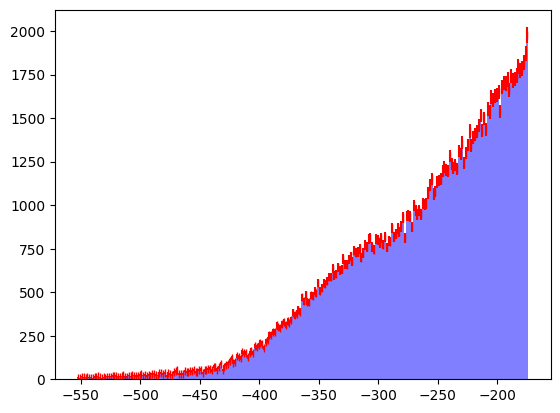

In [299]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.show()


In [300]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, ThermalDistributionModel #Modelli vari, l'ultimo è Fermi (o Bose)

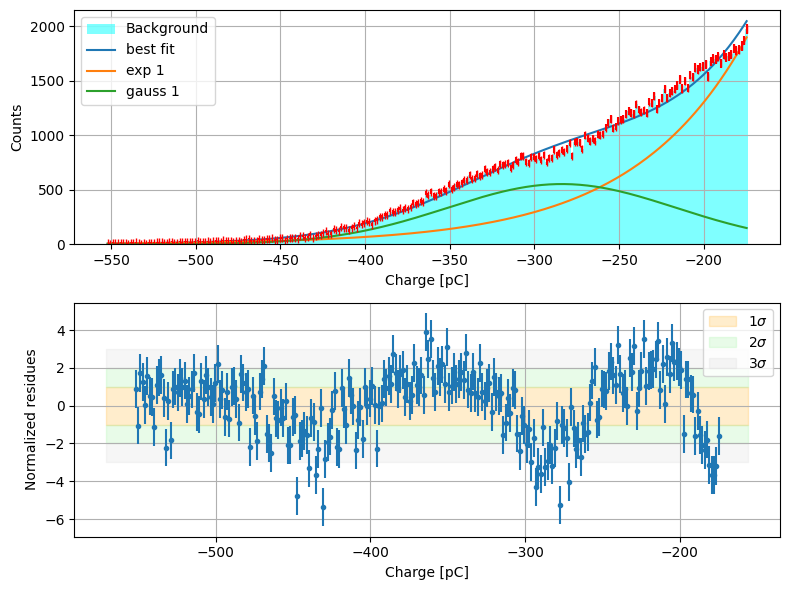

[[Model]]
    (Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 120
    # data points      = 250
    # variables        = 5
    chi-square         = 779.337019
    reduced chi-square = 3.18096742
    Akaike info crit   = 294.245666
    Bayesian info crit = 311.852971
    R-squared          = 0.99999021
[[Variables]]
    e1_amplitude:  25483.1423 +/- 1193.00058 (4.68%) (init = 56563.32)
    e1_decay:     -67.2781926 +/- 1.24744809 (1.85%) (init = -65.63594)
    g1_amplitude:  93253.8004 +/- 4989.67046 (5.35%) (init = 282298.6)
    g1_center:    -283.833066 +/- 2.61497282 (0.92%) (init = -219.4914)
    g1_sigma:      67.3494943 +/- 1.83319825 (2.72%) (init = 47.71782)
    g1_fwhm:       158.595934 +/- 4.31685193 (2.72%) == '2.3548200*g1_sigma'
    g1_height:     552.385531 +/- 16.7105308 (3.03%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
[[Correlations]] (unreported correlations are < 0.10

In [312]:
exp1 = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')  #Gaussiana
 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Aggiorno i parametri, aggiungendo la gaussiana

model = exp1 + gauss1  #Definisco il modello gaussiana + esponenziale

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le due componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')

ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|')
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())